In [9]:
import torch
import torchvision
import torchvision.transforms as transforms
import os 
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.preprocessing import LabelEncoder
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

### Load the Data

In [10]:
train_data_dir = './data/train'
validation_data_dir = './data/val'

### Creating a Custom Dataset Object for PyTorch

In [11]:
class CelebrityDataset(Dataset):
    '''
    This is the Dataset class for the Celebrity data. It's meant to conform
    to PyTorch's structure with the DataLoader. Typically, Datasets are premade,
    but this allows for customization.
    '''
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.encoder = LabelEncoder()
        self.image_paths, self.labels = self.load_data()

    def load_data(self):
        '''
        Interface method, called in the constructor of DataLoader (I think)
        This traverses through the ./data folder to assign X and y data to respective
        arrays.

        Returns the image_paths and numerical_labels (classes in a numeric encoding)
        '''
        fpath = f"{self.data_dir}"
        sub_folders = [item for item in os.listdir(fpath) if os.path.isdir(os.path.join(fpath, item))]
        image_paths = []
        labels = []
        for subfolder in sub_folders:
            images_subfolder = os.listdir(f"{fpath}/{subfolder}")
            for image in images_subfolder:
                fpath_i = f"{self.data_dir}/{subfolder}/{image}"
                image_paths.append(fpath_i)
                labels.append(f"{subfolder}")
                
        # print(image_paths)
        # print(labels)
        numerical_labels = self.encoder.fit_transform(labels)
        
        return image_paths, numerical_labels

    def __len__(self):
        '''
        Returns the length of the dataset.
        '''
        return len(self.image_paths)

    def __getitem__(self, idx):
        '''
        gets the item in a Dataset by index. Called by iterators.
        '''
        # Load an image and its label based on the index 'idx'.
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        
        # Load and preprocess the image
        image = Image.open(image_path)
        if image.mode != 'RGB':
            image = image.convert('RGB')
        if self.transform:
            image = self.transform(image)
            # print(image.shape)

        return image, label


### Initializing the DataLoaders

In [12]:
transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

dataset_train = CelebrityDataset(data_dir=train_data_dir, transform=transform)
dataset_val = CelebrityDataset(data_dir=validation_data_dir, transform=transform)

batch_size = 4

trainloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
testloader = DataLoader(dataset_val, batch_size=batch_size, shuffle=True)

### Visualize a Datasample

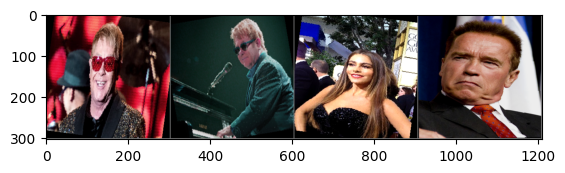

elton_john elton_john sofia_vergara arnold_schwarzenegger


In [13]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels_numeric = next(dataiter)
labels = dataset_train.encoder.inverse_transform(labels_numeric) # decodes the one-hot-encoding of the labels.
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{labels[j]:5s}' for j in range(batch_size)))

### Create a CNN

In [14]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes=14):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc_input_size = self.calculate_fc_input_size()
        self.fc1 = nn.Linear(self.fc_input_size, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 14)

    def calculate_fc_input_size(self):
        # Calculate the size for the first fully connected layer
        x = torch.randn(1, 3, 300, 300)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        return x.view(x.size(0), -1).shape[1]

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
model = CustomCNN()

### Define an Optimizer Function

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

### Train the ImageCNN

In [16]:
def test():
    # Dummy input data with a batch size of 1 and image size 300x300x3
    dummy_input = torch.randn(1, 3, 300, 300)

    # Forward pass to test the model
    output = model(dummy_input)
    print("Output shape:", output.shape)
    print(f"{output}")

test() 
n_epochs = 20
for epoch in range(n_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

    print(f'Epoch: {epoch + 1}, batch #: {i + 1:5d}, loss: {running_loss / 2000:.3f}')

print('Finished Training')


Output shape: torch.Size([1, 14])
tensor([[-0.0052, -0.0187, -0.0950, -0.0933, -0.0541,  0.0554,  0.0407,  0.0142,
          0.0516, -0.0572,  0.1189,  0.0773, -0.1323, -0.0928]],
       grad_fn=<AddmmBackward0>)


Epoch: 1, batch #:    55, loss: 0.073
Epoch: 2, batch #:    55, loss: 0.072
Epoch: 3, batch #:    55, loss: 0.071
Epoch: 4, batch #:    55, loss: 0.070
Epoch: 5, batch #:    55, loss: 0.069
Epoch: 6, batch #:    55, loss: 0.068
Epoch: 7, batch #:    55, loss: 0.065
Epoch: 8, batch #:    55, loss: 0.064
Epoch: 9, batch #:    55, loss: 0.063
Epoch: 10, batch #:    55, loss: 0.063
Epoch: 11, batch #:    55, loss: 0.061
Epoch: 12, batch #:    55, loss: 0.059
Epoch: 13, batch #:    55, loss: 0.057
Epoch: 14, batch #:    55, loss: 0.056
Epoch: 15, batch #:    55, loss: 0.055
Epoch: 16, batch #:    55, loss: 0.051
Epoch: 17, batch #:    55, loss: 0.052
Epoch: 18, batch #:    55, loss: 0.051
Epoch: 19, batch #:    55, loss: 0.048
Epoch: 20, batch #:    55, loss: 0.047
Finished Training


### Test the Model

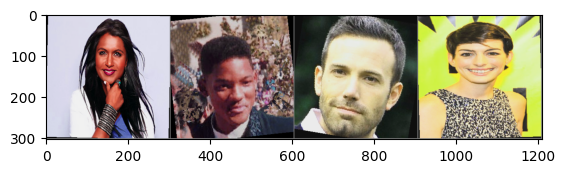

GroundTruth:  mindy_kaling will_smith ben_afflek anne_hathaway
Predicted:  mindy_kaling simon_pegg madonna anne_hathaway


In [17]:
dataiter = iter(testloader)
images, labels_numeric = next(dataiter)
labels = dataset_train.encoder.inverse_transform(labels_numeric) # decodes the one-hot-encoding of the labels.
# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{labels[j]:5s}' for j in range(4)))

outputs = model(images)
_, predicted_numeric = torch.max(outputs, 1)
predicted = dataset_train.encoder.inverse_transform(predicted_numeric) # decodes the one-hot-encoding of the labels.
print('Predicted: ', ' '.join(f'{predicted[j]:5s}'
                              for j in range(4)))